# Problem Statement:

With a dataset of over 50million hand drawn drawings and 340 labels, we are tasked by Google to build a better classifier for the existing Quick, Draw! dataset. This will have an immediate impact on handwriting recognition and its robust applications in areas including OCR (Optical Character Recognition), ASR (Automatic Speech Recognition) & NLP (Natural Language Processing).

As data scientists, we would like to build a predictive model that can predict accurately the label of the drawings with a maximum of 3 guesses. Hence our target metric is accuracy or more specifically the top 3 accuracy. With a better predictive model, Google will be able to immediately improve their handwritten recognition models.

## Dataset

This data and challenge comes from [this kaggle competition](https://www.kaggle.com/c/quickdraw-doodle-recognition)

## Imports and libraries

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import top_k_categorical_accuracy

%matplotlib inline

import os
import ast
from glob import glob
from tqdm.notebook import tqdm 
from PIL import Image, ImageDraw
import math

In [2]:
## External add on to notify when cell is executed.
%load_ext jupyternotify

<IPython.core.display.Javascript object>

## Data cleaning and EDA

The dataset is from Kaggle and there is no cleaning to be done as the data has been preprocessed by them. There are no missing values and the labels are in the training dataset. 

In [3]:
# take a look at first train set (airplane.csv)
df_train = pd.read_csv('train_simplified/airplane.csv')

In [4]:
df_train[:10]

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",5152802093400064,True,2017-03-08 21:12:07.266040,airplane
1,CA,"[[[2, 14, 34, 126], [57, 45, 38, 47]], [[41, 4...",6622904974311424,False,2017-03-06 21:39:04.690130,airplane
2,US,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",6577010312740864,True,2017-03-23 02:08:35.229980,airplane
3,US,"[[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...",5643224746033152,True,2017-03-10 00:35:17.531970,airplane
4,IL,"[[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...",6670046841536512,True,2017-01-23 18:11:11.658170,airplane
5,US,"[[[195, 164, 127, 40, 13, 0, 4, 28, 93, 172, 2...",5509429904539648,True,2017-03-02 19:06:55.494650,airplane
6,CZ,"[[[105, 102, 106, 112, 126, 133, 137, 139, 209...",4885112569200640,True,2017-03-27 19:32:38.753680,airplane
7,AU,"[[[93, 68, 17, 0, 3, 13, 38, 66, 109, 114, 153...",5445677096108032,True,2017-03-29 09:25:50.212600,airplane
8,MY,"[[[1, 2, 8, 17, 22, 28, 94, 99, 99, 102, 105, ...",6687207765049344,True,2017-03-25 10:17:56.501990,airplane
9,BR,"[[[2, 34, 48, 102, 191], [20, 38, 42, 46, 44]]...",5838857872343040,True,2017-03-15 23:26:35.328150,airplane


In [5]:
# to retain only the python expressions in the values (e.g. remove the single quotes '')

example_10 = [ast.literal_eval(pts) for pts in df_train[:10].drawing.values]

In [6]:
ast.literal_eval(df_train.drawing[0])

[[[167,
   109,
   80,
   69,
   58,
   31,
   57,
   117,
   99,
   52,
   30,
   6,
   1,
   2,
   66,
   98,
   253,
   254,
   246,
   182,
   165],
  [140,
   194,
   227,
   232,
   229,
   229,
   206,
   124,
   123,
   149,
   157,
   159,
   153,
   110,
   82,
   77,
   74,
   109,
   121,
   127,
   120]],
 [[207, 207, 210, 221, 238], [74, 103, 114, 128, 135]],
 [[119, 107, 76, 70, 49, 39, 60, 93], [72, 41, 3, 0, 1, 5, 38, 70]]]

<ipython-input-7-e3e157622b06>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-7-e3e157622b06>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


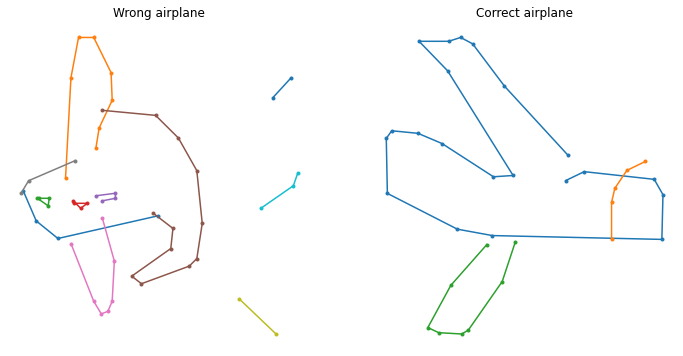

In [7]:
# example of a wrongly drawn airplane and correctly drawn airplane
plt.figure(figsize=(12,6))

for x, y in example_10[1]:
    plt.subplot(1,2,1)
    plt.plot(x, y, marker='.')
    plt.axis('off')
    plt.title('Wrong airplane')
    
for x, y in example_10[0]:
    plt.subplot(1,2,2)
    plt.plot(x, y, marker='.')
    plt.axis('off')
    plt.title('Correct airplane')

We can see that the difference between a False and True recognized airplane. The False one on the left does not look like an airplane and there are also random strokes on the side. The True one on the right looks more like an airplane.  

In [3]:
# lets take a look at 2 correct drawings from 10 random csv files
paths = glob('train_simplified/*.csv') # saves the 340 file paths as a list
columns = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word'] # columns of our train df

In [4]:
sketchlist = []
for i in [0, 10, 20, 30, 40, 100, 150, 200, 250, 300]:
    sketch = pd.read_csv(paths[i], nrows=10) # read in 10 rows from the csv file
    sketch = sketch[sketch.recognized==True].head(2) # take the first 2 Correct drawings
    sketchlist.append(sketch)

sketch_df = pd.DataFrame(np.concatenate(sketchlist), columns = columns)
sketch_df

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",5152802093400064,True,2017-03-08 21:12:07.266040,airplane
1,US,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",6577010312740864,True,2017-03-23 02:08:35.229980,airplane
2,KR,"[[[2, 38, 71, 108, 128, 139], [10, 24, 31, 22,...",5344373355053056,True,2017-03-22 06:30:48.171460,axe
3,SE,"[[[54, 37, 7, 5, 12, 0, 7, 34, 52, 56, 52, 42,...",6545061917491200,True,2017-01-27 21:49:54.406820,axe
4,BR,"[[[48, 119, 208, 222, 228, 209, 175, 80, 25, 7...",4801185506656256,True,2017-01-26 00:40:23.964940,bathtub
5,GB,"[[[17, 230], [138, 136]], [[1, 8, 21, 33, 55, ...",5242011433041920,True,2017-03-21 19:08:39.365000,bathtub
6,US,"[[[0, 11, 23, 50, 72, 96, 97, 132, 158, 224, 2...",4926006882205696,True,2017-03-09 00:28:55.637750,bird
7,US,"[[[65, 194, 221, 240, 250, 255, 251, 242, 227,...",5357674197680128,True,2017-03-29 04:22:58.822970,bird
8,US,"[[[0, 17, 25, 31, 63, 72, 78, 99, 101, 109, 11...",5740525556596736,True,2017-01-25 19:53:24.835000,bread
9,US,"[[[44, 43, 47, 65, 133, 155, 163, 161, 137], [...",6272884819361792,True,2017-03-27 14:35:09.998750,bread


In [8]:
evens = range(0,19,2)
odds = range(1,20, 2)
df1 = sketch_df[sketch_df.index.isin(evens)]
df2 = sketch_df[sketch_df.index.isin(odds)]

example1s = [ast.literal_eval(pts) for pts in df1.drawing.values]
example2s = [ast.literal_eval(pts) for pts in df2.drawing.values]

<ipython-input-12-90ef6f7d35c2>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-12-90ef6f7d35c2>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


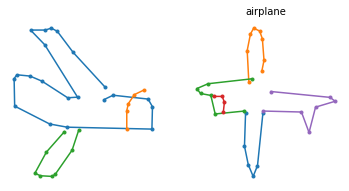

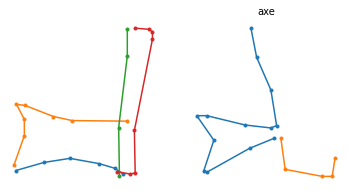

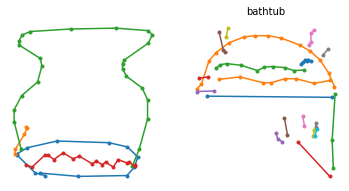

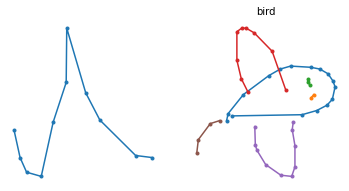

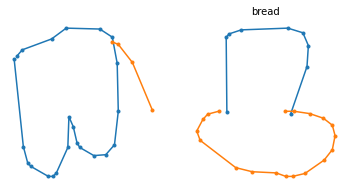

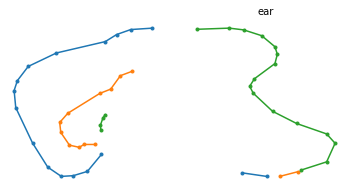

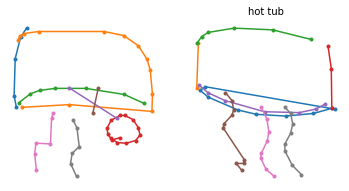

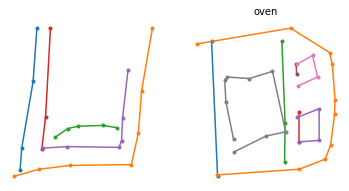

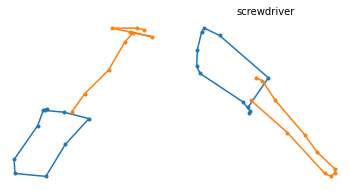

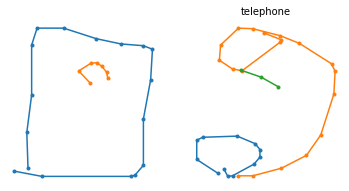

In [12]:
# 2 correct example of each class

labels = df2.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')

    for x,y in example2s[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)

    plt.show()  

Here we see that the images recognized as True comes in different augmentation depending on how the user chooses to start drawing from. The 2 correct Airplanes are facing left and right. The bread is drawn upside down. Screwdriver is facing different angles. This will help our model with generalizing to new images and reduce variance. Also we might not need to manually add a layer for data augmentation.

In [6]:
# 2 wrong example of each class
sketchlist_wrong = []
for i in [0, 10, 20, 30, 40, 100, 150, 200, 250, 300]:
    sketch = pd.read_csv(paths[i], nrows=100) # read in 10 rows from the csv file
    sketch = sketch[sketch.recognized==False].head(2) # take the first 2 Correct drawings
    sketchlist_wrong.append(sketch)

sketch_df_wrong = pd.DataFrame(np.concatenate(sketchlist_wrong), columns = columns)
sketch_df_wrong

,countrycode,drawing,key_id,recognized,timestamp,word
0,CA,"[[[2, 14, 34, 126], [57, 45, 38, 47]], [[41, 4...",6622904974311424,False,2017-03-06 21:39:04.690130,airplane
1,AU,"[[[3, 5, 15], [3, 34, 62]], [[0, 36], [1, 56]]...",4927566257324032,False,2017-03-01 02:33:27.642600,airplane
2,US,"[[[146, 145, 154, 154, 197, 196, 189, 191, 178...",4767264018530304,False,2017-03-09 22:13:02.245390,axe
3,SK,"[[[31, 30, 33, 50, 55, 53, 56, 52, 35, 32, 34]...",5543808265617408,False,2017-03-08 11:16:09.315190,axe
4,RO,"[[[57, 57], [255, 215]], [[133, 122], [252, 20...",5022555733753856,False,2017-03-04 18:36:19.714880,bathtub
5,US,"[[[61, 65], [70, 60]], [[3, 80, 189, 232, 255,...",5844467921715200,False,2017-03-11 01:35:38.598940,bathtub
6,ZA,"[[[28, 25, 36, 49, 70, 88, 113, 126, 139, 157,...",5696703329992704,False,2017-03-10 13:05:10.002030,bird
7,CA,"[[[91, 79, 77, 77, 87], [73, 54, 44, 33, 19]],...",6713028990992384,False,2017-03-04 18:41:53.608630,bird
8,KH,"[[[74, 101, 139, 181, 201, 232, 243, 250, 255,...",4823385550880768,False,2017-03-12 06:51:14.315750,bread
9,PK,"[[[14, 8, 6, 9, 84, 199, 204, 205, 204, 183, 1...",5303740162637824,False,2017-03-02 17:28:00.284910,bread


In [9]:
df3 = sketch_df_wrong[sketch_df_wrong.index.isin(evens)]
df4 = sketch_df_wrong[sketch_df_wrong.index.isin(odds)]

example3 = [ast.literal_eval(pts) for pts in df3.drawing.values]
example4 = [ast.literal_eval(pts) for pts in df4.drawing.values]

<ipython-input-10-bf32040389d8>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-10-bf32040389d8>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


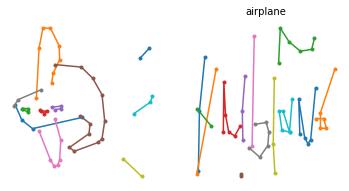

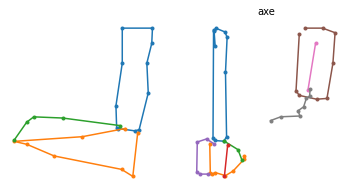

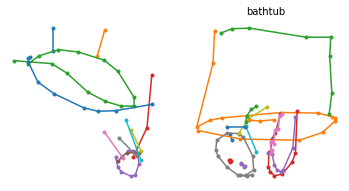

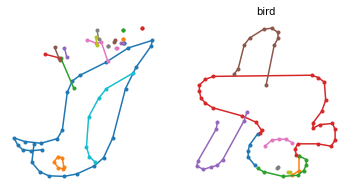

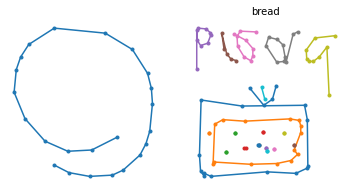

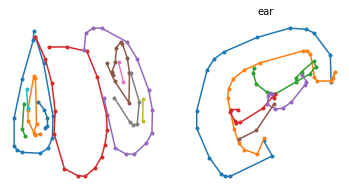

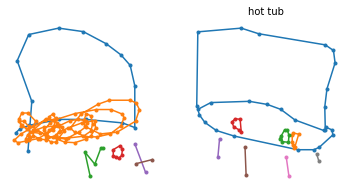

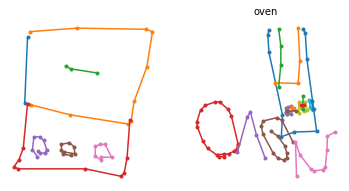

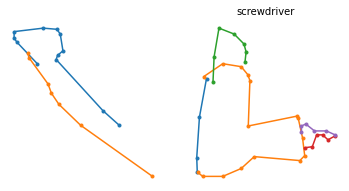

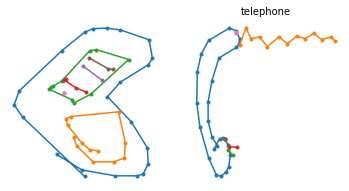

In [10]:
labels = df4.word.tolist()
for i, example in enumerate(example3):
    plt.figure(figsize=(6,3))
    
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')

    for x,y in example4[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)

Here we see the images recognized as False. Most of the drawings do not fit the label and seem to be excessively drawn containing too much information. The wrong airplane is a bunch of scribbles, bathtub contains human in it and bread has the word 'bread' in it. There are however some images that looks to be correct such as the bird on the left and the axe on the left. However the wrong drawings far outweigh those correctly drawn. Hence we will not be including images recognized as False as it might confuse our model. 

In [3]:
# define labels and dimensions of data to be fitted into CNN
classfiles = os.listdir('train_simplified/')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} # get the label names and add underscore

num_classes = 340 # total of 340 classes
imheight, imwidth = 32, 32

In [5]:
numstonames

{0: 'airplane',
 1: 'alarm_clock',
 2: 'ambulance',
 3: 'angel',
 4: 'animal_migration',
 5: 'ant',
 6: 'anvil',
 7: 'apple',
 8: 'arm',
 9: 'asparagus',
 10: 'axe',
 11: 'backpack',
 12: 'banana',
 13: 'bandage',
 14: 'barn',
 15: 'baseball_bat',
 16: 'baseball',
 17: 'basket',
 18: 'basketball',
 19: 'bat',
 20: 'bathtub',
 21: 'beach',
 22: 'bear',
 23: 'beard',
 24: 'bed',
 25: 'bee',
 26: 'belt',
 27: 'bench',
 28: 'bicycle',
 29: 'binoculars',
 30: 'bird',
 31: 'birthday_cake',
 32: 'blackberry',
 33: 'blueberry',
 34: 'book',
 35: 'boomerang',
 36: 'bottlecap',
 37: 'bowtie',
 38: 'bracelet',
 39: 'brain',
 40: 'bread',
 41: 'bridge',
 42: 'broccoli',
 43: 'broom',
 44: 'bucket',
 45: 'bulldozer',
 46: 'bus',
 47: 'bush',
 48: 'butterfly',
 49: 'cactus',
 50: 'cake',
 51: 'calculator',
 52: 'calendar',
 53: 'camel',
 54: 'camera',
 55: 'camouflage',
 56: 'campfire',
 57: 'candle',
 58: 'cannon',
 59: 'canoe',
 60: 'car',
 61: 'carrot',
 62: 'castle',
 63: 'cat',
 64: 'ceiling_fa

In [6]:
inv_numstonames = {v.replace("_", " "): k for k, v in numstonames.items()}
inv_numstonames

{'airplane': 0,
 'alarm clock': 1,
 'ambulance': 2,
 'angel': 3,
 'animal migration': 4,
 'ant': 5,
 'anvil': 6,
 'apple': 7,
 'arm': 8,
 'asparagus': 9,
 'axe': 10,
 'backpack': 11,
 'banana': 12,
 'bandage': 13,
 'barn': 14,
 'baseball bat': 15,
 'baseball': 16,
 'basket': 17,
 'basketball': 18,
 'bat': 19,
 'bathtub': 20,
 'beach': 21,
 'bear': 22,
 'beard': 23,
 'bed': 24,
 'bee': 25,
 'belt': 26,
 'bench': 27,
 'bicycle': 28,
 'binoculars': 29,
 'bird': 30,
 'birthday cake': 31,
 'blackberry': 32,
 'blueberry': 33,
 'book': 34,
 'boomerang': 35,
 'bottlecap': 36,
 'bowtie': 37,
 'bracelet': 38,
 'brain': 39,
 'bread': 40,
 'bridge': 41,
 'broccoli': 42,
 'broom': 43,
 'bucket': 44,
 'bulldozer': 45,
 'bus': 46,
 'bush': 47,
 'butterfly': 48,
 'cactus': 49,
 'cake': 50,
 'calculator': 51,
 'calendar': 52,
 'camel': 53,
 'camera': 54,
 'camouflage': 55,
 'campfire': 56,
 'candle': 57,
 'cannon': 58,
 'canoe': 59,
 'car': 60,
 'carrot': 61,
 'castle': 62,
 'cat': 63,
 'ceiling fan': 

We have the dictionary numstonames to replace our model predictions which will be outputted as integers from 0-339 back to words.

The inv_numstonames is to convert our dataframe that will be read in into integers 0-339.

In [4]:
def draw_resize(drawing):
    """ To convert drawing values into image, resize it to 32,32 and scale it """
    image = Image.new("P", (255,255), color=255) # substatiate image as a 255 color image for CNN model
    image_draw = ImageDraw.Draw(image) # draw a blank image
    for stroke in ast.literal_eval(drawing): # convert drawing column into strokes
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth)) # resize the image dimensions
    return np.array(image)/255

Function to convert strokes into image and resize it to 32,32. Lastly scale it by dividing by 255. Due to limited knowledge in converting the strokes data into images, I used the function from a very helpful kernel. [Source](https://www.kaggle.com/jpmiller/image-based-cnn/notebook?scriptVersionId=6576524&cellId=15)

In [56]:
%%notify
trainlist = []
for i in tqdm(range(0,340)): # iterate through all csvs in paths
    sketch = pd.read_csv(paths[i], usecols=['drawing', 'recognized', 'word'], nrows=2500) # skiprows=[i for i in range(1,1501)], # read csv and only take 3 columns
    sketch = sketch[sketch.recognized==True].head(2000) # take only correct sketches, 3000 rows use up 90+% memory
    trainlist.append(sketch) # append into trainlist

train_df = pd.DataFrame(np.concatenate(trainlist), columns = ['drawing', 'recognized', 'word']) # convert into df

  0%|          | 0/340 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [57]:
train_df.drop(columns = 'recognized', inplace=True)

In [58]:
train_df.word = train_df.word.map(inv_numstonames)

In [59]:
train_df

,drawing,word
0,"[[[167, 109, 80, 69, 58, 31, 57, 117, 99, 52, ...",0
1,"[[[90, 88, 95, 104, 112, 122], [65, 31, 12, 0,...",0
2,"[[[82, 49, 15, 4, 0, 5, 30, 85, 89, 93, 112, 1...",0
3,"[[[64, 38, 23, 8, 0, 6, 26, 68], [74, 77, 84, ...",0
4,"[[[195, 164, 127, 40, 13, 0, 4, 28, 93, 172, 2...",0
...,...,...
25495,"[[[50, 0, 8, 50, 85], [35, 1, 0, 16, 19]], [[8...",339
25496,"[[[53, 163, 56, 0, 44, 143, 140, 118, 87, 39, ...",339
25497,"[[[0, 5, 19, 34, 43, 48, 59, 62, 53, 52, 92, 1...",339
25498,"[[[0, 16, 30, 39, 64, 76, 123, 126, 151, 170, ...",339


Dropping the 'recognized' column as we will not be needing it and also convert the label from string to integers from 0 to 339 to define the 340 classes which is needed for tensorflow's to_categorical function.

In [60]:
# train_df.to_csv('550-625img_for_collab.csv', index=False)

In [61]:
%%notify
# convert drawing values into readable format for CNN
train_df.drawing = train_df.drawing.map(draw_resize)

<IPython.core.display.Javascript object>

In [62]:
# change labels into one hot encoded data which can be fitted into CNN
y = tf.keras.utils.to_categorical(np.array(train_df['word']), num_classes=num_classes)

We read in 2000 true images per class (340 classes) to get a total of 680000 images. Then we map the function 'draw_resize' to convert the drawing columns into an image array that can be fed into the CNN model. This is the most i can squeeze into the CPU memory as the drawing of the image and resizing it takes up the bulk of the memory. 

We also convert the word column into one hot encoded data which contains a sparse matrix of 0s and 1s that can be fed into the CNN model. 

## Train Test Split 

In [63]:
%%notify
X_train, X_test, y_train, y_test = train_test_split(train_df.drawing,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.1, # 0.2, 0.3
                                                    stratify=y)

<IPython.core.display.Javascript object>

Our test size is 0.1 and we stratify=y to keep the 340 class ratio the same for train and test.

In [64]:
print(X_train.shape, y_train.shape, "\n", X_test.shape, y_test.shape)

(22950,) (22950, 340) 
 (2550,) (2550, 340)


In [65]:
%%notify
train_tf = tf.constant(X_train.tolist(), shape = (X_train.shape[0], imheight, imwidth, 1))

<IPython.core.display.Javascript object>

In [66]:
train_tf_label = tf.constant(y_train.tolist())

In [67]:
test_tf = tf.constant(X_test.tolist(), shape = (X_test.shape[0], imheight, imwidth, 1))

In [68]:
test_tf_label = tf.constant(y_test.tolist())

In [69]:
print(train_tf.shape, train_tf_label.shape, "\n", test_tf.shape, test_tf_label.shape)

(22950, 128, 128, 1) (22950, 340) 
 (2550, 128, 128, 1) (2550, 340)


In [70]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_tf, train_tf_label))
# train_dataset = train_dataset.shuffle(len(train_tf))
# train_dataset = train_dataset.repeat(2)
train_dataset = train_dataset.batch(32, drop_remainder=True)

In [71]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_tf, test_tf_label))
# test_dataset = test_dataset.shuffle(len(test_tf))
# test_dataset = test_dataset.repeat(2)
test_dataset = test_dataset.batch(32, drop_remainder=True)

In [72]:
train_dataset

<BatchDataset shapes: ((32, 128, 128, 1), (32, 340)), types: (tf.float64, tf.float32)>

We reshape our image array into (32, 32, 1) before putting it into the TensorFlow dataset pipeline. We will be sending out 32 samples in each batch to reduce memory usage during the model training.

## Basic CNN model Architecture

In [42]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(1360, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 680)               2785960   
_________________________________________________________________
dropout (Dropout)            (None, 680)               0

Tried out different Architecture but realized that adding too many layers increases the training time exponentially. Hence decided to only include 2 Convolution layers which gives the 3D image depth and retain the height and width dimensions. 2 MaxPooling layers to extract features and reduce the height and width dimensions by half each. We then flatten the 3D image into a flat 1 dimensional array and include 1 dense layer of 680 nodes followed by dropping half of it to regularize our model and reduce variance. Finally we have a last dense layer with 'softmax' activation that outputs a vector of 340 probabilities (for 340 class) summing to 1.  

In [10]:
# metrics for prediction and submission to kaggle
# function from tensorflow.keras library 
def top_3_accuracy(true_classes, predicted_classes): 
    top3 = top_k_categorical_accuracy(true_classes, predicted_classes, 3)
    return top3

In [33]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.005, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=5) 
callbacks = [reduceLROnPlat, earlystop]

To set up callbacks for reducing learning rate and early stopping. To reduce learning rate by half when val_loss does not improve (reduce) by 0.005 for 3 epochs. Also to stop running the model when val_top_3_accuracy does not improve for 5 epochs. 

In [45]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

We will be setting our loss as 'categorical_crossentropy' as there are multiple classes (340) and we will be monitoring the metrics accuracy and top_3_accuracy.

In [46]:
%%notify
history = model.fit(train_dataset,
          batch_size = 32,
          epochs = 10,
          validation_data = test_dataset,
          callbacks = callbacks,
          verbose = 1)

Epoch 1/10
57223/57223 [==============================] - 5054s 88ms/step - loss: 2.5709 - accuracy: 0.3964 - top_3_accuracy: 0.6019 - val_loss: 1.8778 - val_accuracy: 0.5326 - val_top_3_accuracy: 0.7409
Epoch 2/10
57223/57223 [==============================] - 4819s 84ms/step - loss: 2.1557 - accuracy: 0.4725 - top_3_accuracy: 0.6857 - val_loss: 1.8257 - val_accuracy: 0.5446 - val_top_3_accuracy: 0.7511
Epoch 3/10
57223/57223 [==============================] - 20431s 357ms/step - loss: 2.0731 - accuracy: 0.4891 - top_3_accuracy: 0.7025 - val_loss: 1.8256 - val_accuracy: 0.5447 - val_top_3_accuracy: 0.7532
Epoch 4/10
57223/57223 [==============================] - 12987s 227ms/step - loss: 2.0362 - accuracy: 0.4968 - top_3_accuracy: 0.7098 - val_loss: 1.8422 - val_accuracy: 0.5440 - val_top_3_accuracy: 0.7511
Epoch 5/10
57223/57223 [==============================] - 5260s 92ms/step - loss: 2.0195 - accuracy: 0.5004 - top_3_accuracy: 0.7138 - val_loss: 1.8119 - val_accuracy: 0.5512 - val

<IPython.core.display.Javascript object>

In [56]:
#model save
# model.save("saved_models/3000img")

INFO:tensorflow:Assets written to: saved_models/3000img\assets


In [33]:
!dir saved_models

 Volume in drive C is OS
 Volume Serial Number is 880D-7B05

 Directory of C:\Users\zende\Desktop\DSI\roughpaper\materials\project_capstone\Quick, Draw! Doodle Recognition Challenge\saved_models

28/07/2021  01:13 am    <DIR>          .
28/07/2021  01:13 am    <DIR>          ..
22/07/2021  10:22 pm    <DIR>          .ipynb_checkpoints
25/07/2021  07:29 pm    <DIR>          3000img
22/07/2021  10:16 pm    <DIR>          my_model_2000img
28/07/2021  01:13 am    <DIR>          vgg_1000img_model
28/07/2021  01:13 am    <DIR>          vgg_500img_model
               0 File(s)              0 bytes
               7 Dir(s)  313,697,996,800 bytes free


In [43]:
# to load model
best_model = tf.keras.models.load_model("saved_models/my_model_2000img", custom_objects={'top_3_accuracy':top_3_accuracy})

In [44]:
best_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 680)              

## Model performance

In [320]:
model.evaluate(test_dataset)

4250/4250 [==============================] - 32s 8ms/step - loss: 1.7429 - accuracy: 0.5655 - top_3_accuracy: 0.7669


[1.742902398109436, 0.5655146837234497, 0.7668970823287964]

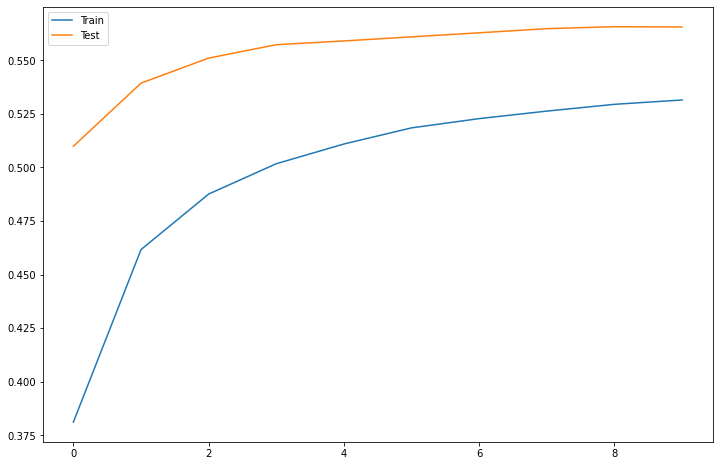

In [321]:
plt.figure(figsize = (12,8))

plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Test')

plt.legend()

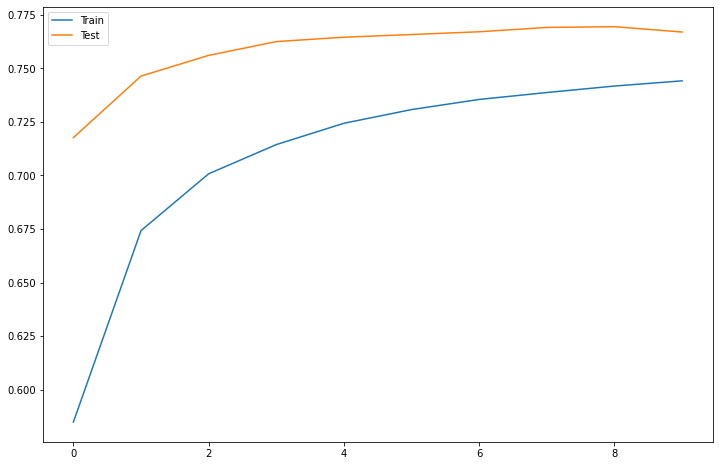

In [322]:
plt.figure(figsize = (12,8))

plt.plot(history.history['top_3_accuracy'], label = 'Train')
plt.plot(history.history['val_top_3_accuracy'], label = 'Test')

plt.legend()

Our custom CNN model performs quite well with a validation accuracy of 0.56 and top 3 accuracy of 0.76. The graph does not show signs of overfitting, the test is performing better than the train score and the lines are very near convergence. This shows that our model will generalize well to new images and there is low variance. 

## Transfer learning from Tensorflow 

### VGG16 model with 32x32 (1000image per class)

In [25]:
# create the base pre-trained model
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(imheight, imwidth, 3))

In [26]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [27]:
len(base_model.layers)

19

In [28]:
# freeze all convolutional VGG16 layers
for layer in base_model.layers:
    #print(layer.name)
    layer.trainable = False

In [29]:
vgg_to_rgb_model = Sequential()
vgg_to_rgb_model.add(Conv2D(3, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1), name='3layers_for_vgg'))
vgg_to_rgb_model.add(base_model)
vgg_to_rgb_model.add(Flatten())
vgg_to_rgb_model.add(Dense(512, activation='relu'))
vgg_to_rgb_model.add(Dropout(0.3))
vgg_to_rgb_model.add(Dense(num_classes, activation='softmax'))

vgg_to_rgb_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
3layers_for_vgg (Conv2D)     (None, 32, 32, 3)         30        
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 680)               348840    
_________________________________________________________________
dropout (Dropout)            (None, 680)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 340)               231540    
Total params: 15,295,098
Trainable params: 580,410
Non-trainable params: 14,714,688
______________________________________

In [30]:
for layer in vgg_to_rgb_model.layers:
    print(layer.name)
    print(layer.trainable)

3layers_for_vgg
True
vgg16
True
flatten
True
dense
True
dropout
True
dense_1
True


In [31]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=3) 
callbacks = [reduceLROnPlat, earlystop]

In [32]:
vgg_to_rgb_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

In [33]:
%%notify
history_vgg = vgg_to_rgb_model.fit(train_dataset,
          batch_size = 32,
          epochs = 4,
          validation_data = test_dataset,
          callbacks = callbacks,
          verbose = 1)

Epoch 1/4
  275/19125 [..............................] - ETA: 3:44:56 - loss: 5.6534 - accuracy: 0.0162 - top_3_accuracy: 0.0393

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

Was not able to run VGG16 model on my notebook. Hence i used google colab to run it. [Colab](https://colab.research.google.com/drive/1YqRAJRwymRgK2DhF1yZQFdqZVx7wwa9V?usp=sharing)

This model was trained with 32x32 images for 1000 images per class totaling 340k images. I first instantiate the VGG16 base model and freeze all layers as we do not have the computing power nor time to run through all of them. I also included a Conv2D layer before the VGG16 base model to create 3 layers (32x32x3) as the original image is greyscale and of 32x32x1 dimension. I then flatten the 3D image into a flat 1 dimensional array and include 1 dense layer of 512 nodes followed by dropping 30% of it to regularize our model and reduce variance. Finally we have a last dense layer with 'softmax' activation that outputs a vector of 340 probabilities (for 340 class) summing to 1.    

The results were not as good as the original CNN model i ran in the notebook. (val_top_3_acc of 0.7669). The VGG16 model was only able to get a val_top_3_acc of 0.57.

This might be due to the limited RAM allocated (12gb) in Google colab, i was only able to run 1000image per class before going over the allocated RAM. Another reason is that VGG16 model is trained on 224x224 images while our images are 32x32. The pre-trained model weights are meant for images of 224x224. 

In [36]:
vgg_model = tf.keras.models.load_model("saved_models/vgg_1000img_model", custom_objects={'top_3_accuracy':top_3_accuracy})

In [37]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
3layers_for_vgg (Conv2D)     (None, 32, 32, 3)         30        
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 340)               174420    
Total params: 15,151,794
Trainable params: 15,151,794
Non-trainable params: 0
____________________________________________

In [39]:
vgg_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

In [40]:
vgg_model.evaluate(test_dataset)

2125/2125 [==============================] - 278s 131ms/step - loss: 2.5948 - accuracy: 0.3795 - top_3_accuracy: 0.5892


[2.5948307514190674, 0.37954410910606384, 0.5891764760017395]

### VGG16 model with 128x128 (75image per class)

In [11]:
vgg_model_128 = tf.keras.models.load_model("saved_models/vgg_50img128x128_model", custom_objects={'top_3_accuracy':top_3_accuracy})

In [35]:
vgg_model_128.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
3layers_for_vgg (Conv2D)     (None, 128, 128, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 340)               174420    
Total params: 15,151,794
Trainable params: 15,151,794
Non-trainable params: 0
__________________________________________

In [36]:
vgg_model_128.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

In [73]:
vgg_model_128.evaluate(test_dataset)

79/79 [==============================] - 158s 2s/step - loss: 1.6551 - accuracy: 0.5641 - top_3_accuracy: 0.7844


[1.6550629138946533, 0.5640822649002075, 0.784414529800415]

We got a much better score of 0.78 for top 3 accuracy with the VGG16 model with 128x128 images.

The model trained with a bigger dimension of image proves to be better for the VGG model as the weights are trained with 224x224 images. Downsizing our dimensions too much gives us a worse score than the custom CNN model. One drawback of a bigger dimension is that I was not able to read in as much images. I was only able to read in 75 images before the RAM usage in Google Colab crashed the session. 

## Submissions

### Basic CNN model

In [47]:
# Read the test csv data 
test = pd.read_csv('test_simplified.csv', usecols = ['key_id', 'drawing'])

,key_id,drawing
0,9000003627287624,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


In [48]:
%%notify
test.drawing = test.drawing.map(draw_resize)

<IPython.core.display.Javascript object>

In [49]:
test.head()

,key_id,drawing
0,9000003627287624,"[[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
1,9000010688666847,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
2,9000023642890129,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
3,9000038588854897,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,9000052667981386,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [52]:
sub_test_tf = tf.constant(test.drawing.tolist(), shape = (test.shape[0], imheight, imwidth, 1))

In [54]:
sub_preds = best_model.predict(sub_test_tf)

In [60]:
sub_preds_num = np.argsort(-sub_preds)[:, 0:3]

In [69]:
preds_df = pd.DataFrame({'first': sub_preds_num[:,0], 'second': sub_preds_num[:,1], 'third': sub_preds_num[:,2]})
preds_df = preds_df.replace(numstonames)
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

,first,second,third
0,radio,stereo,motorbike
1,hockey_puck,pool,belt
2,castle,The_Great_Wall_of_China,camel
3,mountain,tent,triangle
4,campfire,feather,waterslide
...,...,...,...
112194,blueberry,apple,circle
112195,skull,mushroom,rain
112196,broccoli,rain,tree
112197,brain,backpack,camouflage


In [80]:
preds_df.words.head()

0                  radio stereo motorbike
1                   hockey_puck pool belt
2    castle The_Great_Wall_of_China camel
3                  mountain tent triangle
4             campfire feather waterslide
Name: words, dtype: object

In [75]:
test['word'] = preds_df.words.values

In [77]:
submission = test[['key_id', 'word']]

In [79]:
submission.to_csv('kaggle_subs/kag_sub_CNN2000.csv', index=False)

Got a kaggle score of 0.60811 for custom CNN model

### VGG16 128x128 model

In [5]:
# Read the test csv data 
test = pd.read_csv('test_simplified.csv', usecols = ['key_id', 'drawing'])

In [6]:
%%notify
test.drawing = test.drawing.map(draw_resize)

<IPython.core.display.Javascript object>

In [7]:
sub_test_tf = tf.constant(test.drawing.tolist(), shape = (test.shape[0], imheight, imwidth, 1))

In [12]:
sub_preds = vgg_model_128.predict(sub_test_tf)
sub_preds_num = np.argsort(-sub_preds)[:, 0:3]

KeyboardInterrupt: 

In [69]:
preds_df = pd.DataFrame({'first': sub_preds_num[:,0], 'second': sub_preds_num[:,1], 'third': sub_preds_num[:,2]})
preds_df = preds_df.replace(numstonames)
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

,first,second,third
0,radio,stereo,motorbike
1,hockey_puck,pool,belt
2,castle,The_Great_Wall_of_China,camel
3,mountain,tent,triangle
4,campfire,feather,waterslide
...,...,...,...
112194,blueberry,apple,circle
112195,skull,mushroom,rain
112196,broccoli,rain,tree
112197,brain,backpack,camouflage


In [80]:
preds_df.words.head()

0                  radio stereo motorbike
1                   hockey_puck pool belt
2    castle The_Great_Wall_of_China camel
3                  mountain tent triangle
4             campfire feather waterslide
Name: words, dtype: object

In [75]:
test['word'] = preds_df.words.values

In [77]:
submission = test[['key_id', 'word']]

In [79]:
submission.to_csv('kaggle_subs/kag_sub_VGG_128.csv', index=False)

## Summary 

| Models          | Train top 3 accuracy | Test top 3 accuracy | Kaggle Score |
|-----------------|----------------------|---------------------|--------------|
| Custom CNN      | 0.74                 | 0.76                | 0.61         |
| VGG16 (32x32)   | 0.55                 | 0.57                | Did not try  |
| VGG16 (128x128) | 0.76                 | ***0.78***                |0.62              |

Our best model is the VGG16 with 128x128 images. It is evident that a higher dimension image is better for a pre-trained model. However the tradeoff is that we are not able to read in a lot of images due to RAM limitations. The train score and test score do not show signs of overfitting as the scores are pretty close 0.76 and 0.78 respectively. However we only got 0.62 for the kaggle score. One likely reason is our model has not trained on enough images from the train set and it is not able to generalize well to new images outside our test set. There are over 50million images and we only trained on less than a million images. 

**Limitations**:
Our model is only able to predict images from the 340 classes. It will not be able to predict drawings out of the 340 classes. It will instead predict the class that is closest to the 'never-before-seen' image. It is also not trained on colored drawing and will predict colored drawings as if it were grayscale. 

**Further improvements**:
However our model is still able to predict drawings quite well with 3 guesses. Given more time and with a more powerful cloud computer, we can improve our model by reading in 224x224 images instead and training on the entire train dataset.  

## Conclusion

Google will be able to build upon our model and further improve it with their expertise and computing power. One way they can capitalize on an improved model will be to create a toddler programme/application that is able to guide the toddler if he/she is drawing the right image. This will help toddlers learn how to draw and develop artistic talent at an early age. 